# DL1 Assignment2 - Q1.1 draft code

This is a small help from us to save you some coding. This notebook is **not** graded, you are free to edit it.

Further advise:
1. Start with File/Save a copy in Drive
2. Set GPU usage under Runtime/Change runtime type/Hardware accelerator.

In [1]:
!pip install timm

In [2]:
import torch
from torch import nn
import timm
from torchvision import models
from matplotlib import pyplot as plt
from typing import Callable
import numpy as np
%matplotlib inline

In [3]:
def vit_s_8():
    """ViT-S/8 is not a default torchvision model, so we provide it by timm"""
    # Accuracy approximation comes from
    # https://openreview.net/pdf?id=LtKcMgGOeLt
    # and DINO
    # https://arxiv.org/abs/2104.14294
    return timm.create_model('vit_small_patch8_224')

# Model definitions
# Optional Q: These are uncalled functions. What do you think would happen
# if we called all of them once? Why didn't we do that?
model_defs = [
    vit_s_8,
    models.vit_b_32,
    models.vgg11,
    models.vgg11_bn,
    models.resnet18,
    models.densenet121,
    models.mobilenet_v3_small,
]

# Accuracies per model
model_accs = {
    'vit_s_8': 80., # Approximated
    'vit_b_32' : 75.912,
    'vgg11' : 69.02,
    'vgg11_bn' : 70.37,
    'resnet18' : 69.758,
    'densenet121' : 74.434,
    'mobilenet_v3_small' : 67.668,
}

def measure_runtime_per_forward(model:nn.Module, no_grad:bool, batch_size:int=8):
    """Measures the time for a single pass in milliseconds"""

    # Generate fake RGB input (224x224)
    #######################
    # PUT YOUR CODE HERE  #
    #######################
    inp = torch.rand(batch_size, 3, 224, 224).cuda()
    #######################
    # END OF YOUR CODE    #
    #######################

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()

    # Run the model
    #######################
    # PUT YOUR CODE HERE  #
    #######################
    if no_grad:
      with torch.no_grad():
          preds = model(inp)
    else:
      preds = model(inp)

    memory_usage = torch.cuda.memory_allocated() / 2**20
    #######################
    # END OF YOUR CODE    #
    #######################

    end.record()
    torch.cuda.synchronize()
    preds.detach()
    del preds
    inp.detach()
    del inp
    return start.elapsed_time(end), memory_usage

def evaluate_model(model_def:Callable, no_grad:bool, batch_size:int=8):

    # Retreive initial memory allocation
    initial_vram = torch.cuda.memory_allocated() / 2**20

    # Define model
    model = model_def().cuda().eval()
    # Access name as: model.__name__

    # Parameters that need to be filled
    n_params = None
    times, vrams = [], []
    mean_time = None
    mean_vram = None

    #######################
    # PUT YOUR CODE HERE  #
    #######################

    # Step 1: Calculate the number of **trainable** parameters
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Step 2: Warm up with a few passes
    for _ in range(5):
         temp, memory_usage = measure_runtime_per_forward(model, no_grad, batch_size)
    # Step 3: Run N forward passes and save the runtime +
    #         the vram allocated by the model
    for _ in range(40):
        time, memory_usage = measure_runtime_per_forward(model, no_grad, batch_size)
        times.append(time)
        # vram = torch.cuda.memory_allocated()  # VRAM allocated after inference
        vrams.append(memory_usage - initial_vram)
    # Step 4: Take the mean, preferably with dropping possible outliers
    threshold = 3
    times = np.array(times)
    mean_t = np.mean(times, axis=0)
    std_t = np.std(times, axis=0) + 1e-15
    times = [x for x in times if ((x - mean_t)/std_t <  threshold)]
    # vrams = list(filter(lambda x: x >= 0, vrams))
    vrams = np.array(vrams)
    mean_m = np.mean(vrams, axis=0)
    std_m = np.std(vrams, axis=0) + 1e-15
    vrams = [x for x in vrams if ((x - mean_m)/std_m <  threshold )]

    mean_vram = sum(vrams) / len(vrams)
    mean_time = sum(times) / len(times)
    #######################
    # END OF YOUR CODE    #
    #######################

    # Clean up space for the model
    del model
    torch.cuda.empty_cache()

    return mean_time, mean_vram, n_params

vit_s_8
vit_b_32
vgg11
vgg11_bn
resnet18
densenet121
mobilenet_v3_small


Model,Top1 Accuracy,Batch Time (ms),Image Time (ms),Ram (MB),Num Parameters
vit_s_8,80.00%,109.22,15.206,104.871,"21,670,272"
vit_b_32,75.91%,28.3968,7.94473,341.798,"88,224,232"
vgg11,69.02%,26.7714,6.89958,511.833,"132,863,336"
vgg11_bn,70.37%,29.0436,6.84425,511.88,"132,868,840"
resnet18,69.76%,7.94149,2.77632,49.3149,"11,689,512"
densenet121,74.43%,22.9325,16.7801,35.4834,"7,978,856"
mobilenet_v3_small,67.67%,6.46745,6.46738,14.4297,"2,542,856"


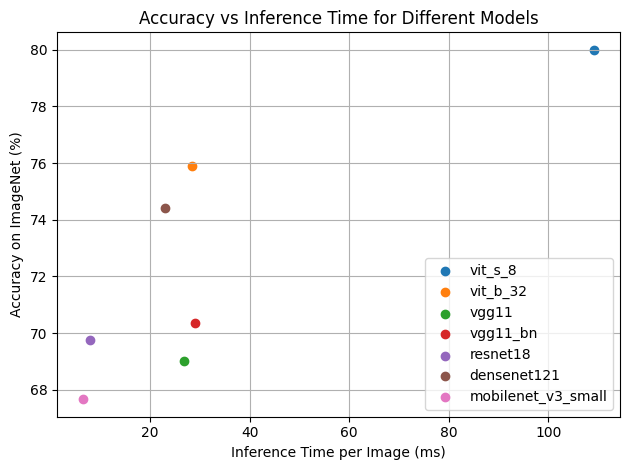

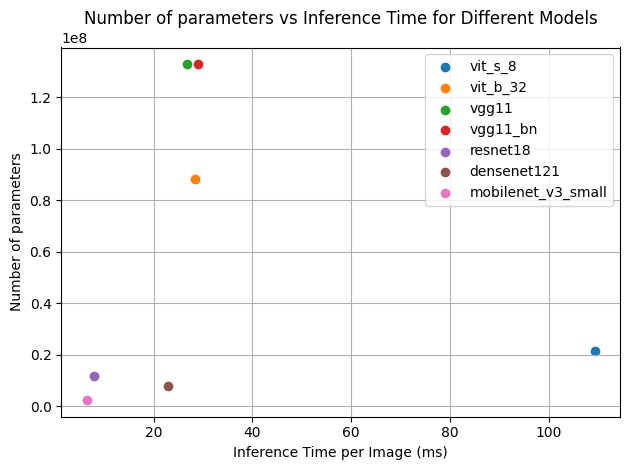

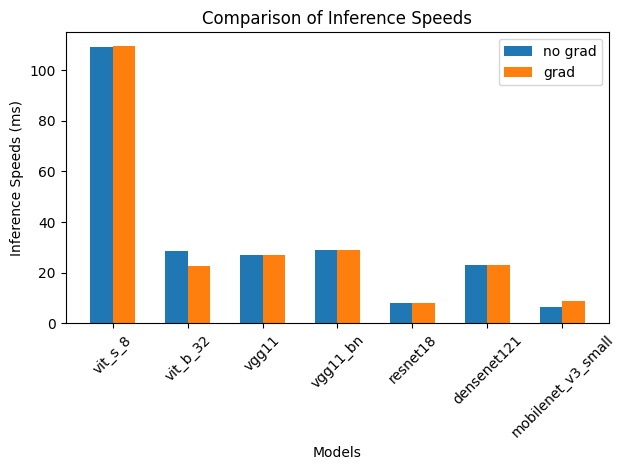

vit_s_8
vit_b_32
vgg11
vgg11_bn
resnet18
densenet121
mobilenet_v3_small


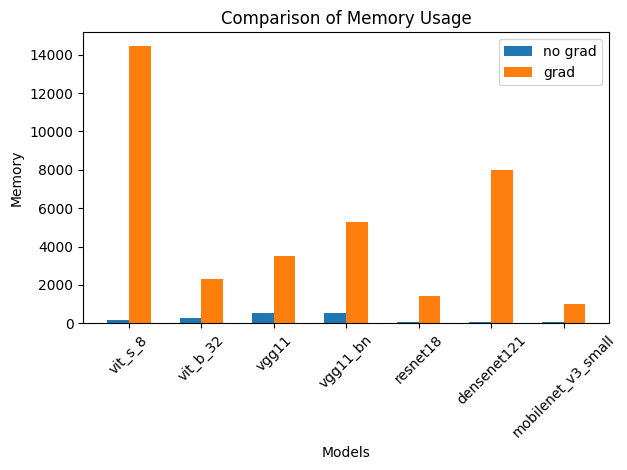

In [4]:
#######################
# PUT YOUR CODE HERE  #
#######################
import tabulate
from IPython.display import display, HTML
import numpy as np

def show_scatter_plot(model_names, xdata, ydata, xname, yname, title, legent_loc='lower right'):
  for i in range(len(model_names)):
    plt.scatter(xdata[i], ydata[i], marker='o', label=model_names[i])
  plt.xlabel(xname)
  plt.ylabel(yname)
  plt.title(title)
  plt.grid(True)
  plt.legend(loc=legent_loc)
  plt.tight_layout()
  plt.show()

def show_bar_plot(model_names, data1, data2, xname, yname, title):
  plt.bar([i - 0.15 for i in range(len(model_names))], data1, width=0.3, label='no grad')
  plt.bar([i + 0.15 for i in range(len(model_names))], data2, width=0.3, label='grad')
  plt.xlabel(xname)
  plt.ylabel(yname)
  plt.title(title)
  plt.xticks(range(len(model_names)), model_names, rotation=45)
  plt.legend()
  plt.tight_layout()
  plt.show()

# seed = 42
# np.random.seed(seed)
# torch.manual_seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# Make your plots here with matplotlib
model_names, inference_times = [], []
memory, number_parameters, table = [], [], []
time_grad, vram_grad = [], []
# Example usage of the above functions:
for model_def in model_defs:
      name = model_def.__name__
      print(name)
      time1, vram1, n_params1 = evaluate_model(model_def, no_grad=True, batch_size=8) # Run for batch = 8
      inference_times.append(time1)
      number_parameters.append(n_params1)
      memory.append(vram1)

      time2, vram2, n_param2 = evaluate_model(model_def, no_grad=True, batch_size=1) # Run for batch = 1

      time3, vram3, n_param3 = evaluate_model(model_def, no_grad=False, batch_size=8) # Run for batch=8, with grad
      time_grad.append(time3)
      vram_grad.append(vram3)
      model_names.append(name)

      table.append([name, f"{model_accs[name]:4.2f}%", "{:,}".format(time1), "{:,}".format(time2), "{:,}".format(vram1), "{:,}".format(n_params1)])
      # break

# (a)
html_table = tabulate.tabulate(table, tablefmt='html', headers=["Model", "Top1 Accuracy", "Batch Time (ms)", "Image Time (ms)", "Ram (MB)", "Num Parameters"], colalign=("right", "center", "center", "center", "center"))
styled_html_table = f"<style> table, th, td {{ border: 1px solid black; border-collapse: collapse; padding: 8px; }} th, td {{ border-right: 1px solid black; }} </style>{html_table}"
display(HTML(styled_html_table))
accuracies = [model_accs[name] for name in model_names]
show_scatter_plot(model_names, inference_times, accuracies, 'Inference Time per Image (ms)', 'Accuracy on ImageNet (%)', 'Accuracy vs Inference Time for Different Models')
show_scatter_plot(model_names, inference_times, number_parameters, 'Inference Time per Image (ms)', 'Number of parameters', 'Number of parameters vs Inference Time for Different Models', 'upper right')

# (b)
show_bar_plot(model_names, inference_times, time_grad, 'Models', 'Inference Speeds (ms)', 'Comparison of Inference Speeds')
# inference_times, time_grad = [], []

# (c)
model_names = []
vram_no_grad_64, vram_grad_64 = [], []
for model_def in model_defs:
      name = model_def.__name__
      print(name)
      model_names.append(name)
      time, vram1, n_param = evaluate_model(model_def, no_grad=True, batch_size=64)
      vram_no_grad_64.append(vram1)
      torch.cuda.empty_cache()

for model_def in model_defs:
      name = model_def.__name__
      time, vram2, n_param = evaluate_model(model_def, no_grad=False, batch_size=64)
      vram_grad_64.append(vram2)
      del model_def
      torch.cuda.empty_cache()
      # break

show_bar_plot(model_names, vram_no_grad_64, vram_grad_64, 'Models', 'Memory', 'Comparison of Memory Usage')
#######################
# END OF YOUR CODE    #
#######################